# Setup

In [1]:
import os
import math
import sys
import torch
import re
import numpy as np
from types import SimpleNamespace as ns
from collections import namedtuple

In [2]:
dim3 = namedtuple("dim3", ["x", "y", "z"], defaults=(1, 1))

In [3]:
d = dim3(2, 3)
d

dim3(x=2, y=3, z=1)

In [4]:
d.x, d.y

(2, 3)

In [5]:
np.set_printoptions(precision=2, linewidth=140)
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)

In [6]:
sys.path.insert(0, "..")
from utils import show_img, load_cuda, cuda_begin, cdiv

In [7]:
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
torch.manual_seed(42);

In [8]:
m1 = torch.rand(5120, 256)
m1s = m1[:4]
m2 = torch.rand(256, 5120)
m2s = m2[:, :4]

# Reminder

### 2d Python kernel

In [9]:
def blk_kernel2d(f, blocks, threads, *args):
    for i0 in range(blocks.y):
        for i1 in range(blocks.x):
            for j0 in range(threads.y):
                for j1 in range(threads.x):
                    f(dim3(i1, i0), dim3(j1, j0), threads, *args)

In [10]:
def matmul_bk(blockIdx, threadIdx, blockDim, m, n, out, h, w, k):
    r = blockIdx.y * blockDim.y + threadIdx.y
    c = blockIdx.x * blockDim.x + threadIdx.x

    if r >= h or c >= w:
        return
    o = 0.0
    for i in range(k):
        o += m[r * k + i] * n[i * w + c]
    out[r * w + c] = o

In [11]:
def matmul_2d(m, n):
    h, k = m.shape
    k2, w = n.shape
    assert k == k2, "Size mismatch!"
    output = torch.zeros(h, w, dtype=m.dtype)
    tpb = dim3(16, 16)
    blocks = dim3(cdiv(w, tpb.x), cdiv(h, tpb.y))
    blk_kernel2d(
        matmul_bk, blocks, tpb, m.flatten(), n.flatten(), output.flatten(), h, w, k
    )
    return output

In [12]:
torch.isclose(matmul_2d(m1s, m2s), m1s @ m2s).all()

tensor(True)

### CUDA

In [13]:
cuda_src = (
    cuda_begin
    + r"""
__global__ void matmul_k(float* m, float* n, float* out, int h, int w, int k) {
    int r = blockIdx.y * blockDim.y + threadIdx.y;
    int c = blockIdx.x * blockDim.x + threadIdx.x;

    if (r >= h || c >= w) return;
    float o = 0;
    for (int i = 0; i<k; i++) o += m[r*k+i] * n[i*w+c];
    out[r*w+c] = o;
}

torch::Tensor matmul(torch::Tensor m, torch::Tensor n) {
    CHECK_INPUT(m); CHECK_INPUT(n);
    int h = m.size(0);
    int w = n.size(1);
    int k = m.size(1);
    TORCH_CHECK(k==n.size(0), "Size mismatch!");
    auto output = torch::zeros({h, w}, m.options());
    
    dim3 tpb(16, 16);
    dim3 blocks(cdiv(w, tpb.x), cdiv(h, tpb.y));
    matmul_k<<<blocks, tpb>>>(
       m.data_ptr<float>(), n.data_ptr<float>(), output.data_ptr<float>(), h, w, k
    );
    C10_CUDA_KERNEL_LAUNCH_CHECK();
    return output;
}

"""
)

In [14]:
fname = "matmul"

In [15]:
def get_sig(fname, src):
    res = re.findall(rf"^(.+\s+{fname}\(.*?\))\s*{{?\s*$", src, re.MULTILINE)
    return res[0] + ";" if res else None

In [16]:
cpp_src = get_sig(fname, cuda_src)
cpp_src

'torch::Tensor matmul(torch::Tensor m, torch::Tensor n);'

In [17]:
module = load_cuda(cuda_src, cpp_src, [fname])

In [18]:
m1c, m2c = m1.contiguous().cuda(), m2.contiguous().cuda()

In [19]:
module.matmul(m1c, m2c).shape

torch.Size([5120, 5120])

In [20]:
torch.isclose(module.matmul(m1c, m2c), m1c @ m2c).all()

tensor(False, device='cuda:0')

In [21]:
%%timeit -n 10
module.matmul(m1c, m2c)
torch.cuda.synchronize()

6.2 ms ± 27.1 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


When I removed the call to the kernel itself, it took around 50μs (0.05 ms) to run, so that's the overhead of the call on my machine.

# Shared Memory

One of the issues with the CUDA kernel we just wrote is that this snippet runs as many times as we have elements to compute in the output matrix, and it keeps accessing global memory (e.g., the objects `m` and `n`), which is "slow".

```cpp
    for (int i = 0; i<k; i++) o += m[r*k+i] * n[i*w+c];

```

It would be much better if we could use "shared" memory, which is significantly faster. The main issue is that "shared" memory is smaller, there is not much of it. We can't naively just upload the entire matrices `m` and `n` in shared memory.

To overcome this issue, we can use a "tiling" approach.

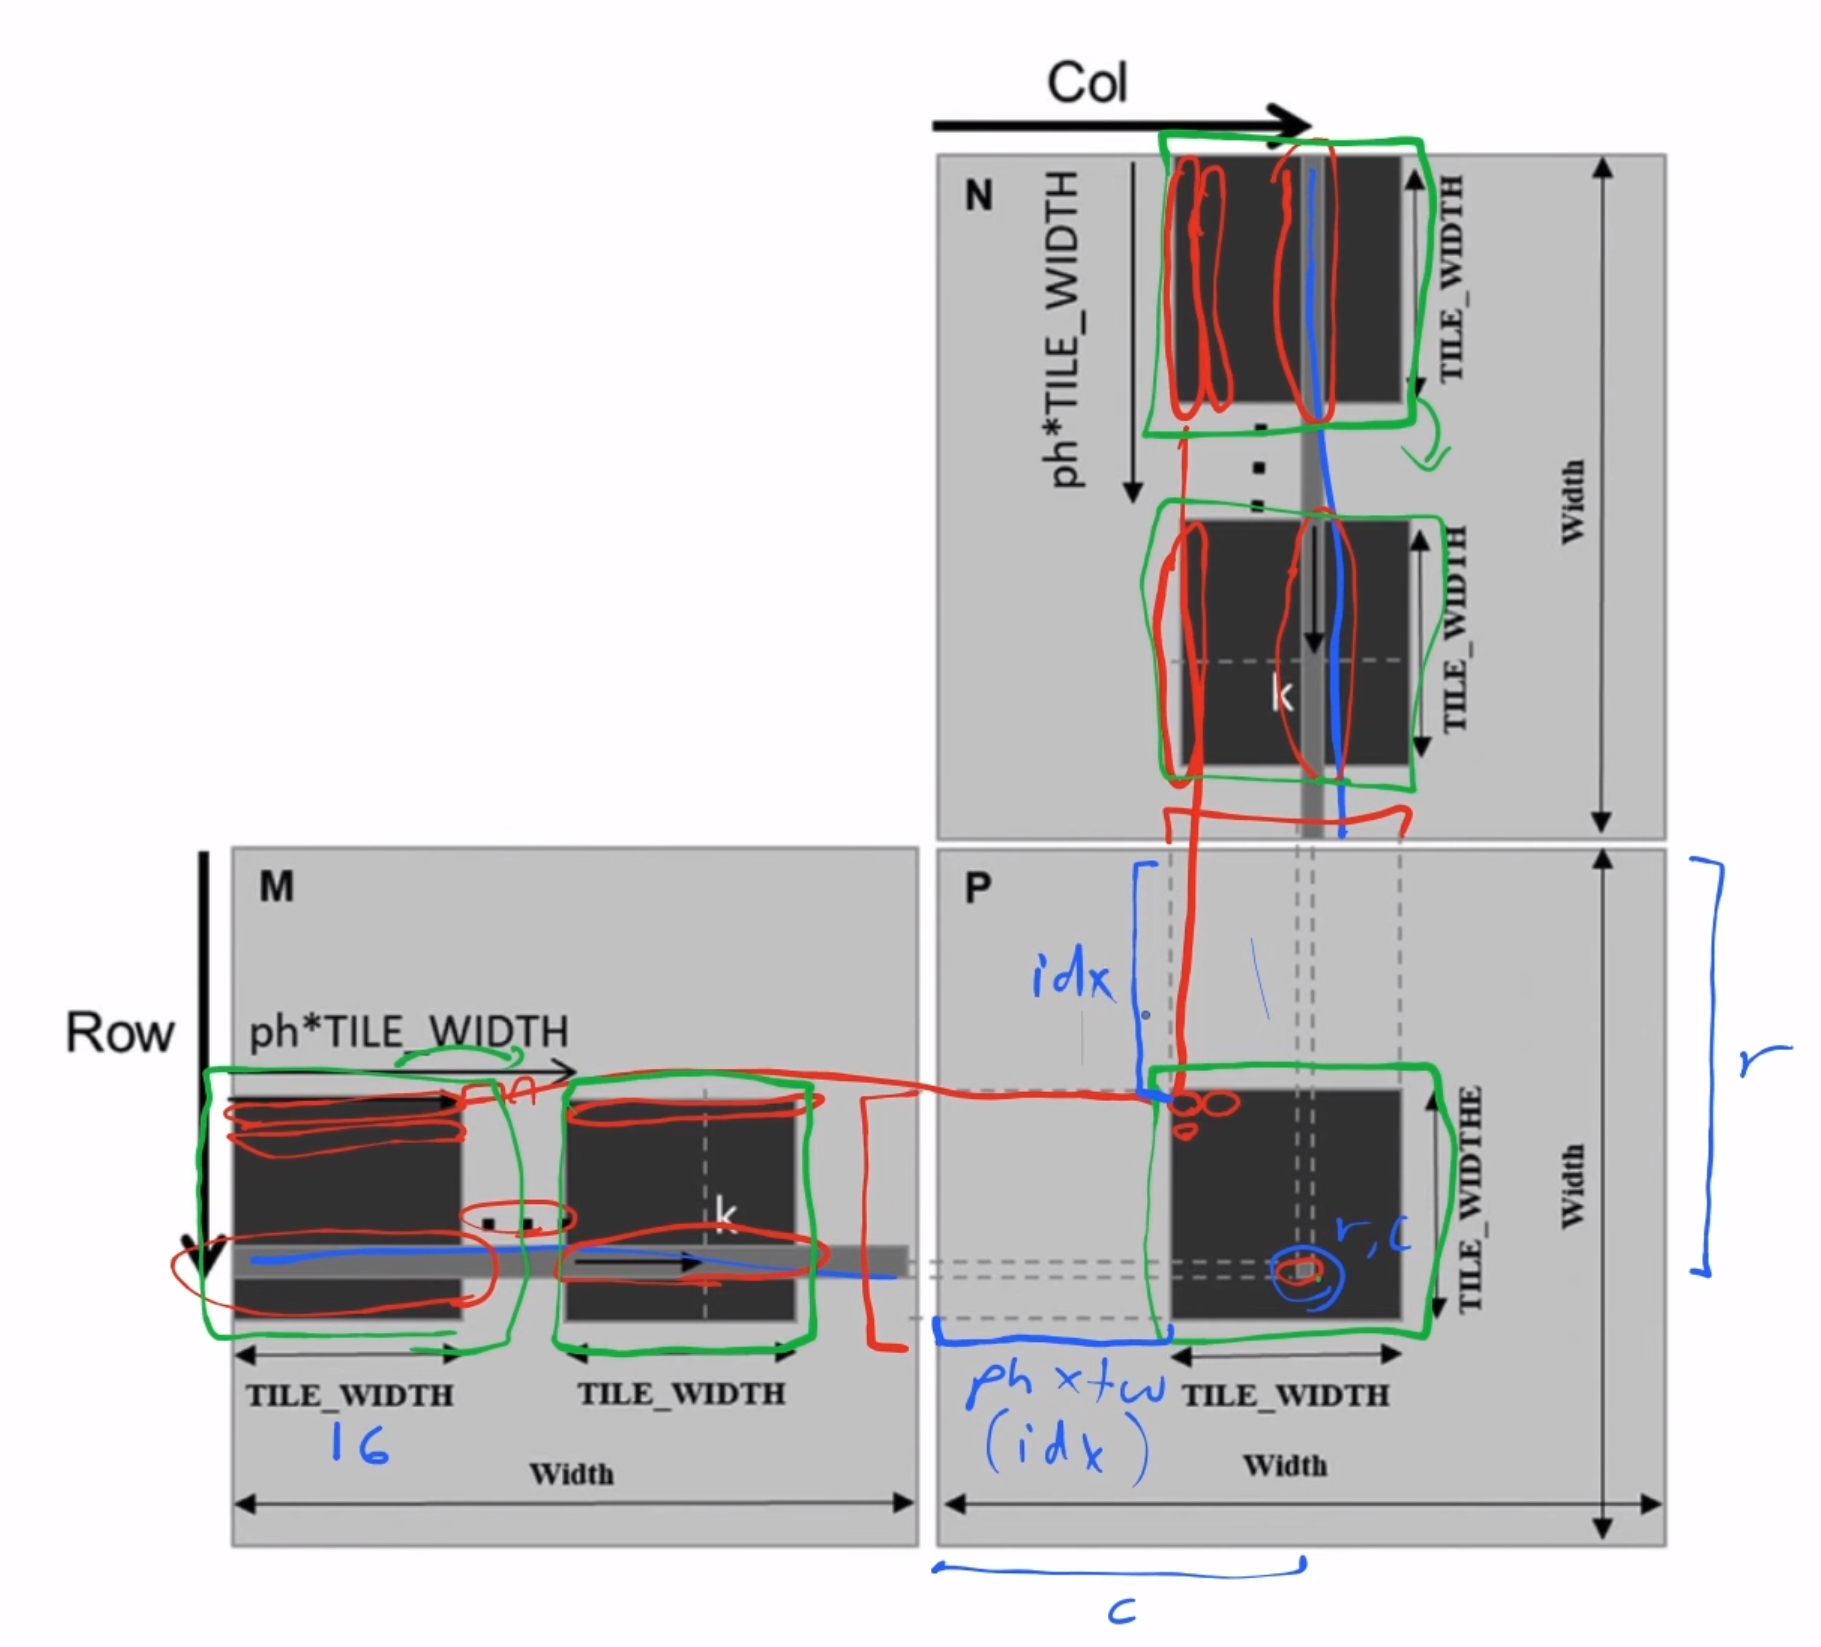

### Python

In [22]:
a = torch.zeros(5)
b, c = a[:3], a[3:]

In [23]:
b[1] = 2
c[0] = 6
a

tensor([0., 2., 0., 6., 0.])

In [24]:
def blk_kernel2d_shar(f, blocks, threads, sh_sz, *args, **kwargs):
    for i0 in range(blocks.y):
        for i1 in range(blocks.x):
            shared = torch.zeros(sh_sz)
            f(dim3(i1, i0), threads, shared, *args, **kwargs)

In [25]:
def matmul_tiled_bk(blockIdx, blockDim, shared, m, n, out, h, w, k, tw):
    shar_sz = tw * tw
    ms, ns = shared[:shar_sz], shared[shar_sz:]

    for ph in range(cdiv(k, tw)):
        idx = ph * tw
        # fill shared
        for tr in range(blockDim.y):
            for tc in range(blockDim.x):
                r, c = blockIdx.y * blockDim.y + tr, blockIdx.x * blockDim.x + tc
                ms[tr * tw + tc] = (
                    m[tc + idx + r * k] if r < h and idx + tc < k else 0.0
                )
                ns[tr * tw + tc] = (
                    n[(tr + idx) * w + c] if c < w and idx + tr < k else 0.0
                )

        # do dotprods from shared
        for tr in range(blockDim.y):
            for tc in range(blockDim.x):
                r, c = blockIdx.y * blockDim.y + tr, blockIdx.x * blockDim.x + tc
                for i in range(tw):
                    if r * w + c < len(out):
                        out[r * w + c] += ms[tr * tw + i] * ns[tw * i + tc]

Notably, we index the matrices in the shared memory `ms` and `ns` with `[tr * tw + tc]` instead of `[tr + tc]` because the matrices `ms` and `ns` have been flatten.

If we have a tile that goes off the edge of the two input matrices, we fill the remaining of the tile with zeros ("padding").

In [26]:
def matmul_2d(m, n, tw=16):
    h, k = m.shape
    k2, w = n.shape
    assert k == k2, "Size mismatch!"

    output = torch.zeros(h, w, dtype=m.dtype)
    tpb = dim3(tw, tw)
    blocks = dim3(cdiv(w, tpb.x), cdiv(h, tpb.y))
    blk_kernel2d_shar(
        matmul_tiled_bk,
        blocks,
        tpb,
        tw * tw * 2,
        m.flatten(),
        n.flatten(),
        output.flatten(),
        h,
        w,
        k,
        tw=tw,
    )
    return output

In [27]:
m1s.shape, m2.shape

(torch.Size([4, 256]), torch.Size([256, 5120]))

In [28]:
torch.isclose(matmul_2d(m1s, m2s, tw=16), m1s @ m2s).all()

tensor(True)

### Python run_threads

Let's refactor the previous code to make it clear when we are dispatching code to the different CUDA threads.

In [29]:
def run_threads(f, blockDim, *args, **kwargs):
    for i0 in range(blockDim.y):
        for i1 in range(blockDim.x):
            f(i0, i1, *args, **kwargs)

In [30]:
def matmul_tile_bk(blockIdx, blockDim, shared, m, n, out, h, w, k, tw):
    shar_sz = tw * tw
    ms, ns = shared[:shar_sz], shared[shar_sz:]

    def get_rc(t, tc):
        return blockIdx.y * blockDim.y + t, blockIdx.x * blockDim.x + tc

    def fill_shared_tk(tr, tc, ph):
        r, c = get_rc(tr, tc)
        ms[tr * tw + tc] = m[tc + idx + r * k] if r < h and idx + tc < k else 0.0
        ns[tr * tw + tc] = n[(tr + idx) * w + c] if c < w and idx + tr < k else 0.0

    def dotprod_tk(t, tc):
        r, c = get_rc(tr, tc)
        for i in range(tw):
            if r * w + c < len(out):
                out[r * w + c] += ms[tr * tw + i] * ns[tw * i + tc]

    for ph in range(cdiv(k, tw)):
        run_threads(fill_shared_tk, blockDim, ph)
        run_threads(dotprod_tk, blockDim)

In [31]:
def matmul_2d(m, n, tw=16):
    h, k = m.shape
    k2, w = n.shape
    assert k == k2, "Size mismatch!"

    output = torch.zeros(h, w, dtype=m.dtype)
    tpb = dim3(tw, tw)
    blocks = dim3(cdiv(w, tpb.x), cdiv(h, tpb.y))
    blk_kernel2d_shar(
        matmul_tiled_bk,
        blocks,
        tpb,
        tw * tw * 2,
        m.flatten(),
        n.flatten(),
        output.flatten(),
        h,
        w,
        k,
        tw=tw,
    )
    return output

In [32]:
torch.isclose(matmul_2d(m1s, m2s, tw=16), m1s @ m2s).all()

tensor(True)

### Python threads

Let's ignore the GIL limitation, and mimic in Python the behaviour we want to have in CUDA.

In [33]:
import threading
from threading import Barrier, Thread
from concurrent.futures import ThreadPoolExecutor

In [34]:
def g(x, sb):
    print(x)
    sb.wait()
    print(-x)
    sb.wait()
    print(x * 10)

In [35]:
num = 3
sb = Barrier(num)
with ThreadPoolExecutor(num) as ex:
    list(ex.map(lambda i: g(i, sb), range(1, num + 1)))

1
2
3
-3
-1
-2
10
30
20


The barriers `sb` are there to tell the computer to wait until `num` threads have reached that point before continue to execute the rest of the code. We can use that to synchronize the threads. 

In our specific example we can use a `Barrier` to wait until all threads have done filling the tiled matrices in the shared memory, before computing the dot product operations.

In [36]:
def blk_kernel2d_shar(f, blocks, tpb, sh_sz, *args, **kwargs):
    for i0 in range(blocks.y):
        for i1 in range(blocks.x):
            shar = torch.zeros(sh_sz)
            syncb = Barrier(tpb.y * tpb.x)
            threads = [
                Thread(
                    target=f,
                    args=(dim3(i1, i0), dim3(p, o), tpb, shar, syncb, *args),
                    kwargs=kwargs,
                )
                for o in range(tpb.y)
                for p in range(tpb.x)
            ]
            for tr in threads:
                tr.start()

            for tc in threads:
                tc.join()

In [37]:
def matmul_tiled_bk(
    blockIdx, threadIdx, blockDim, shared, syncb, m, n, out, h, w, k, tw
):
    tc, tr = threadIdx.x, threadIdx.y
    r = blockIdx.y * blockDim.y + tr
    c = blockIdx.x * blockDim.x + tc

    shar_sz = tw * tw
    ms, ns = shared[:shar_sz], shared[shar_sz:]

    p = 0.0
    for ph in range(cdiv(k, tw)):
        ms[tr * tw + tc] = (
            m[tc + ph * tw + r * k] if r < h and (ph * tw + tc) < k else 0.0
        )
        ns[tr * tw + tc] = (
            n[(tr + ph * tw) * w + c] if c < w and (ph * tw + tr) < k else 0.0
        )
        syncb.wait()
        for i in range(tw):
            p += ms[tr * tw + i] * ns[tw * i + tc]
        syncb.wait()

    if r < h and c < w:
        out[r * w + c] = p

In [38]:
def matmul_2d(m, n, tw=16):
    h, k = m.shape
    k2, w = n.shape
    assert k == k2, "Size mismatch!"

    output = torch.zeros(h, w, dtype=m.dtype)
    tpb = dim3(tw, tw)
    blocks = dim3(cdiv(w, tpb.x), cdiv(h, tpb.y))
    blk_kernel2d_shar(
        matmul_tiled_bk,
        blocks,
        tpb,
        tw * tw * 2,
        m.flatten(),
        n.flatten(),
        output.flatten(),
        h,
        w,
        k,
        tw=tw,
    )
    return output

In [39]:
torch.isclose(matmul_2d(m1s, m2s, tw=16), m1s @ m2s).all()

tensor(True)

### CUDA dynamic shared

Code auto-generated by ChatGPT-4, using the following prompt:

> Convert the following python code to CUDA C, keeping formatting and variable names the same where possible. You can remove `blockIdx`, `threadIdx`, `blockDim`, shared from the argument list, since they're already provided by CUDA. Change `syncb.wait()` to `__syncthreads`. Use extern `__shared__ float shared[]` to create the `shared` array. Use the C ternary operator to replace the Python equivalent where appropriate. If the Python code uses any non-standard functions, you can assume the same functions are also available to the translated C code with the same name and signature.

The generated code worked first time, although we did some minor cleanups afterwards (e.g. renaming `shared` to `ms`).

In [40]:
cuda_src = (
    cuda_begin
    + r"""
__global__ void matmul_k(float *m, float *n, float *out, int h, int w, int k, int tw) {
    int tc = threadIdx.x;
    int tr = threadIdx.y;
    int r = blockIdx.y * blockDim.y + tr;
    int c = blockIdx.x * blockDim.x + tc;

    extern __shared__ float ms[];
    float *ns = &ms[tw * tw];

    float p = 0.0f;
    for (int ph = 0; ph < cdiv(k, tw); ++ph) {
        int idx = ph * tw;
        ms[tr * tw + tc] = r < h && idx + tc < k ? m[tc + idx + r * k] : 0.0;
        ns[tr * tw + tc] = c < w && idx + tr < k ? n[(tr + idx) * w + c] : 0.0;
        __syncthreads();
        for (int i = 0; i < tw; ++i) {
            p += ms[tr * tw + i] * ns[tw * i + tc];
        }
        __syncthreads();
    }

    if (r < h && c < w) {
        out[r * w + c] = p;
    }
}
"""
)

In [41]:
cuda_src += r"""
torch::Tensor matmul_dyn(torch::Tensor m, torch::Tensor n) {
    CHECK_INPUT(m); CHECK_INPUT(n);
    int h=m.size(0), w=n.size(1), k=m.size(1);
    TORCH_CHECK(k==n.size(0), "Size mismatch!");
    auto output = torch::zeros({h, w}, m.options());

    /*
    cudaDeviceProp devProp;
    CUDA_ERR(cudaGetDeviceProperties(&devProp, 0));
    int maxThreads = devProp.maxThreadsPerBlock;
    size_t requiredSize = static_cast<size_t>(maxThreads) * 2 * sizeof(float);
    size_t size = min(devProp.sharedMemPerBlock, requiredSize);
    int TW = std::sqrt(maxThreads);
    */
    int TW = 16;
    size_t size = TW*TW * 2 * sizeof(float);
    
    dim3 tpb(TW,TW);
    dim3 blocks(cdiv(w, tpb.x), cdiv(h, tpb.y));
    matmul_k<<<blocks, tpb, size>>>(
        m.data_ptr<float>(), n.data_ptr<float>(), output.data_ptr<float>(), h, w, k, TW);
    C10_CUDA_KERNEL_LAUNCH_CHECK();
    return output;
}
"""

In [42]:
fname = "matmul_dyn"

In [43]:
cpp_src = get_sig(fname, cuda_src)
cpp_src

'torch::Tensor matmul_dyn(torch::Tensor m, torch::Tensor n);'

In [44]:
module = load_cuda(cuda_src, cpp_src, [fname], opt=True)

In [45]:
torch.isclose(module.matmul_dyn(m1c, m2c), m1c @ m2c).all()

tensor(False, device='cuda:0')

In [46]:
module.matmul_dyn(m1c, m2c)

tensor([[56.98, 60.02, 60.60,  ..., 57.88, 58.28, 60.45],
        [58.53, 63.83, 59.82,  ..., 60.67, 62.91, 60.79],
        [60.09, 66.28, 63.87,  ..., 62.70, 61.83, 64.68],
        ...,
        [64.25, 66.72, 62.89,  ..., 64.89, 61.55, 66.38],
        [61.05, 63.53, 66.76,  ..., 62.59, 63.57, 68.32],
        [62.07, 65.70, 64.51,  ..., 63.59, 63.10, 67.13]], device='cuda:0')

In [47]:
m1c @ m2c

tensor([[56.98, 60.03, 60.60,  ..., 57.88, 58.28, 60.45],
        [58.53, 63.83, 59.82,  ..., 60.67, 62.91, 60.79],
        [60.09, 66.28, 63.87,  ..., 62.70, 61.83, 64.67],
        ...,
        [64.25, 66.72, 62.89,  ..., 64.89, 61.55, 66.37],
        [61.05, 63.53, 66.76,  ..., 62.59, 63.57, 68.32],
        [62.08, 65.70, 64.51,  ..., 63.59, 63.10, 67.13]], device='cuda:0')

In [48]:
torch.isclose(module.matmul_dyn(m1c, m2c), m1c @ m2c, atol=1e-2)

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]], device='cuda:0')

In [49]:
%%timeit -n 10
module.matmul_dyn(m1c, m2c)
torch.cuda.synchronize()

7.84 ms ± 349 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


This is a little slower than the not-tiled implementation. 

### CUDA static shared

If we don't use dynamic shared memory allocation, we can squeeze a little bit more performance from this kernel.

In [50]:
cuda_src = (
    cuda_begin
    + r"""
constexpr int tw = 16;

__global__ void matmul_ks(float *m, float *n, float *out, int h, int w, int k) {
    __shared__ float ms[tw][tw], ns[tw][tw];
    int tc = threadIdx.x;
    int tr = threadIdx.y;
    int r = blockIdx.y * blockDim.y + tr;
    int c = blockIdx.x * blockDim.x + tc;

    float p = 0.0f;
    for (int ph = 0; ph < cdiv(k, tw); ++ph) {
        int idx = ph * tw;
        ms[tr][tc] = r < h && idx + tc < k ? m[tc + idx + r * k] : 0.0f;
        ns[tr][tc] = c < w && idx + tr < k ? n[(tr + idx) * w + c] : 0.0f;
        __syncthreads();
        for (int i = 0; i < tw; ++i) {
            p += ms[tr][i] * ns[i][tc];
        }
        __syncthreads();
    }

    if (r < h && c < w) {
        out[r * w + c] = p;
    }
}

torch::Tensor matmul_static(torch::Tensor m, torch::Tensor n) {
    CHECK_INPUT(m); CHECK_INPUT(n);
    int h=m.size(0), w=n.size(1), k=m.size(1);
    TORCH_CHECK(k==n.size(0), "Size mismatch!");
    auto output = torch::zeros({h, w}, m.options());

    dim3 tpb(tw, tw);
    dim3 blocks(cdiv(w, tpb.x), cdiv(h, tpb.y));
    matmul_ks<<<blocks, tpb>>>(
        m.data_ptr<float>(), n.data_ptr<float>(), output.data_ptr<float>(), h, w, k);
    C10_CUDA_KERNEL_LAUNCH_CHECK();
    return output;
}
"""
)

In [51]:
fname = "matmul_static"

In [52]:
cpp_src = get_sig(fname, cuda_src)
cpp_src

'torch::Tensor matmul_static(torch::Tensor m, torch::Tensor n);'

In [53]:
module = load_cuda(cuda_src, cpp_src, [fname], opt=True)

In [54]:
torch.isclose(module.matmul_static(m1c, m2c), m1c @ m2c).all()

tensor(False, device='cuda:0')

In [55]:
%%timeit -n 10
module.matmul_static(m1c, m2c)
torch.cuda.synchronize()

4.49 ms ± 81.7 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


This is much faster now!

### Extra: Optimized Dynamic CUDA with Template

The reason why the dynamic version is significantly slower is that, at compile time, when `tw` is not known, CUDA does not know how to create an optimized piece of code for a range of `tw` values, so it defaults to the smallest possible version.

In [56]:
cuda_src = (
    cuda_begin
    + r"""
template<int tw>
__global__ void matmul_k(float *m, float *n, float *out, int h, int w, int k) {
    int tc = threadIdx.x;
    int tr = threadIdx.y;
    int r = blockIdx.y * blockDim.y + tr;
    int c = blockIdx.x * blockDim.x + tc;

    extern __shared__ float ms[];
    float *ns = &ms[tw * tw];

    float p = 0.0f;
    for (int ph = 0; ph < cdiv(k, tw); ++ph) {
        int idx = ph * tw;
        ms[tr * tw + tc] = r < h && idx + tc < k ? m[tc + idx + r * k] : 0.0f;
        ns[tr * tw + tc] = c < w && idx + tr < k ? n[(tr + idx) * w + c] : 0.0f;
        __syncthreads();
        for (int i = 0; i < tw; ++i) {
            p += ms[tr * tw + i] * ns[tw * i + tc];
        }
        __syncthreads();
    }

    if (r < h && c < w) {
        out[r * w + c] = p;
    }
}
"""
)

In [57]:
cuda_src += r"""
torch::Tensor matmul_dyn1(torch::Tensor m, torch::Tensor n) {
    CHECK_INPUT(m); CHECK_INPUT(n);
    int h=m.size(0), w=n.size(1), k=m.size(1);
    TORCH_CHECK(k==n.size(0), "Size mismatch!");
    auto output = torch::zeros({h, w}, m.options());
    int TW = 16;  // TODO: calculate this dynamically
    size_t size = TW*TW * 2 * sizeof(float) + 1;
    dim3 tpb(TW,TW);
    dim3 blocks(cdiv(w, tpb.x), cdiv(h, tpb.y));
    
    auto f = [&](auto kf) { kf<<<blocks, tpb, size>>>(
        m.data_ptr<float>(), n.data_ptr<float>(), output.data_ptr<float>(), h, w, k);
    };
    switch(TW) {
        case 8: f(matmul_k<8>); break;
        case 16: f(matmul_k<16>); break;
        case 32: f(matmul_k<32>); break;
        default: break;
    }
    C10_CUDA_KERNEL_LAUNCH_CHECK();
    return output;
}
"""

`f` is a lambda function in C++. The `switch` statement tells CUDA to compile three versions of this program, one for each tile width size we specified.

In [58]:
fname = "matmul_dyn1"

In [59]:
cpp_src = get_sig(fname, cuda_src)
cpp_src

'torch::Tensor matmul_dyn1(torch::Tensor m, torch::Tensor n);'

In [60]:
module = load_cuda(cuda_src, cpp_src, [fname], opt=True)

In [61]:
torch.isclose(module.matmul_dyn1(m1c, m2c), m1c @ m2c).all()

tensor(False, device='cuda:0')

In [62]:
%%timeit -n 10
module.matmul_dyn1(m1c, m2c)
torch.cuda.synchronize()

4.5 ms ± 84 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


The results are not the same as the static version!

### Numba

In [63]:
from numba import cuda
from numba.cuda import as_cuda_array as ca

In [64]:
@cuda.jit
def matmul_k_numba(m, n, out, tw):
    cbi, cbd, tid = cuda.blockIdx, cuda.blockDim, cuda.threadIdx
    tc, tr = tid.x, tid.y
    r, c = cbi.y * cbd.y + tr, cbi.x * cbd.x + tc
    h, k = m.shape
    k2, w = n.shape

    shar = cuda.shared.array(0, dtype=np.float32)
    ms, ns = shar[: tw * tw], shar[tw * tw : 2 * tw * tw]

    p = np.float32(0.0)
    for ph in range(math.ceil(k / tw)):
        idx = ph * tw
        ms[tr * tw + tc] = m[r, tc + idx] if r < h and idx + tc < k else 0.0
        ns[tr * tw + tc] = n[tr + idx, c] if c < w and idx + tr < k else 0.0
        cuda.syncthreads()
        for i in range(tw):
            p += ms[tr * tw + i] * ns[i * tw + tc]
        cuda.syncthreads()
    if r < h and c < w:
        out[r, c] = p

In [65]:
def matmul_2d_numba(m, n, tw=16):
    h, k = m.shape
    k2, w = n.shape
    assert k == k2, "Size mismatch!"
    out = torch.zeros(h, w, dtype=m.dtype).cuda()
    dyn_shared_mem_size = 2 * tw * tw * 4
    tpb = tw, tw
    blocks = cdiv(w, tpb[0]), cdiv(h, tpb[1])
    matmul_k_numba[blocks, tpb, 0, dyn_shared_mem_size](ca(m), ca(n), ca(out), tw)
    return out

In [66]:
torch.isclose(matmul_2d_numba(m1c, m2c), m1c @ m2c).all()

tensor(False, device='cuda:0')

In [67]:
%%timeit -n 10
matmul_2d_numba(m1c, m2c)
torch.cuda.synchronize()

44.6 ms ± 995 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Not as fast as handwritten CUDA, but much faster than pure Python.

This is a big win because the compilation time of Numba kernels is much faster than CUDA kernels (~1s compared to 30+s). So this is great for experimenting fast. 

Another advantage is that we don't need to flatten our tensors. We can just wrap them as CUDA arrays with `ca()`. This is convenient because then we can index them as we would in `pytorch`, or use `.shape`.

Another nice thing about numba is that what we did before with the `threading` library, is [fully built-in into `numba`](https://numba.pydata.org/numba-doc/dev/cuda/simulator.html#using-the-simulator).

Jeremy's recommendation is to start with `numba` (with the `NUMBA_ENABLE_CUDASIM` env variable set to `1`), and then ask ChatGPT to convert it to CUDA. He found that ChatGPT does a great job at converting it.